In [3]:
pip install colorama

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, init
import plotly.express as px

import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
from collections import Counter
from wordcloud import WordCloud

In [5]:
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
df = pd.read_csv("/content/sentimentdataset.csv")

In [7]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,15-01-2023 12:30,User123,Twitter,#Nature #Park,15,30,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,15-01-2023 08:45,CommuterX,Twitter,#Traffic #Morning,5,10,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,15-01-2023 15:45,FitnessFan,Instagram,#Fitness #Workout,20,40,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,15-01-2023 18:20,AdventureX,Facebook,#Travel #Adventure,8,15,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,15-01-2023 19:55,ChefCook,Instagram,#Cooking #Food,12,25,Australia,2023,1,15,19


In [8]:
def null_count():
    return pd.DataFrame({'features': df.columns,
                'dtypes': df.dtypes.values,
                'NaN count': df.isnull().sum().values,
                'NaN percentage': df.isnull().sum().values/df.shape[0]}).style.background_gradient(cmap='Set3',low=0.1,high=0.01)
null_count()

,features,dtypes,NaN count,NaN percentage
0,Unnamed: 0.1,int64,0,0.000000
1,Unnamed: 0,int64,0,0.000000
2,Text,object,0,0.000000
3,Sentiment,object,0,0.000000
4,Timestamp,object,0,0.000000
5,User,object,0,0.000000
6,Platform,object,0,0.000000
7,Hashtags,object,0,0.000000
8,Retweets,int64,0,0.000000
9,Likes,int64,0,0.000000


In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Text', 'Sentiment', 'Timestamp', 'User',
       'Platform', 'Hashtags', 'Retweets', 'Likes', 'Country', 'Year', 'Month',
       'Day', 'Hour'],
      dtype='object')

In [11]:
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

Unnamed: 0.1: 732 distinct values
Unnamed: 0: 732 distinct values
Text: 707 distinct values
Sentiment: 279 distinct values
Timestamp: 683 distinct values
User: 685 distinct values
Platform: 4 distinct values
Hashtags: 697 distinct values
Retweets: 26 distinct values
Likes: 38 distinct values
Country: 115 distinct values
Year: 14 distinct values
Month: 12 distinct values
Day: 31 distinct values
Hour: 22 distinct values


## Feature Engineering

In [12]:
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Hashtags','Day', 'Hour','Sentiment'])

In [13]:
df['Platform'] = df['Platform'].str.strip()

In [14]:
df['Platform'].value_counts()

,count
Platform,
Instagram,258
Twitter,243
Facebook,231


In [15]:
df['Country'] = df['Country'].str.strip()

In [16]:
df['Country'].value_counts()

,count
Country,
USA,188
UK,143
Canada,135
Australia,75
India,70
Brazil,17
France,16
Japan,15
Germany,14


In [17]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['Day_of_Week'] = df['Timestamp'].dt.day_name()

In [18]:
month_mapping = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}

df['Month'] = df['Month'].map(month_mapping)

df['Month'] = df['Month'].astype('object')

In [19]:
nltk.download('punkt_tab')

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\s+', ' ', text.strip())
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = " ".join(text.split())
    tokens = word_tokenize(text)

    cleaned_tokens = [stemmer.stem(token) for token in tokens if token.lower() not in stop_words]

    cleaned_text = ' '.join(cleaned_tokens)

    return cleaned_text

df["Clean_Text"] = df["Text"].apply(clean)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [20]:
specified_columns = ['Platform','Country', 'Year','Month','Day_of_Week']

for col in specified_columns:
    total_unique_values = df[col].nunique()
    print(f'Total unique values for {col}: {total_unique_values}')

    top_values = df[col].value_counts()

    colors = [Fore.RED, Fore.GREEN, Fore.YELLOW, Fore.BLUE, Fore.MAGENTA, Fore.CYAN, Fore.WHITE, Fore.LIGHTBLACK_EX, Fore.LIGHTRED_EX, Fore.LIGHTGREEN_EX]

    for i, (value, count) in enumerate(top_values.items()):
        color = colors[i % len(colors)]
        print(f'{color}{value}: {count}{Fore.RESET}')

    print('\n' + '=' * 30 + '\n')

Total unique values for Platform: 3
Instagram: 258
Twitter: 243
Facebook: 231


Total unique values for Country: 33
USA: 188
UK: 143
Canada: 135
Australia: 75
India: 70
Brazil: 17
France: 16
Japan: 15
Germany: 14
Italy: 11
Spain: 6
South Africa: 6
Greece: 5
Netherlands: 4
Switzerland: 3
Sweden: 2
Portugal: 2
Austria: 2
Belgium: 2
Denmark: 2
Czech Republic: 2
Jordan: 1
Peru: 1
Maldives: 1
China: 1
Cambodia: 1
Norway: 1
Colombia: 1
Ireland: 1
Jamaica: 1
Kenya: 1
Scotland: 1
Thailand: 1


Total unique values for Year: 14
2023: 289
2019: 73
2020: 69
2021: 63
2022: 63
2018: 56
2017: 43
2016: 38
2015: 19
2011: 4
2013: 4
2012: 4
2014: 4
2010: 3


Total unique values for Month: 12
February: 85
January: 82
August: 78
September: 77
June: 71
July: 62
April: 51
November: 49
October: 48
May: 46
March: 44
December: 39


Total unique values for Day_of_Week: 7
Sunday: 119
Saturday: 115
Tuesday: 110
Friday: 108
Monday: 97
Thursday: 95
Wednesday: 88




In [21]:
df.head()

,Text,Timestamp,User,Platform,Retweets,Likes,Country,Year,Month,Day_of_Week,Clean_Text
0,Enjoying a beautiful day at the park! ...,2023-01-15 12:30:00,User123,Twitter,15,30,USA,2023,January,Sunday,enjoy beauti day park
1,Traffic was terrible this morning. ...,2023-01-15 08:45:00,CommuterX,Twitter,5,10,Canada,2023,January,Sunday,traffic terribl morn
2,Just finished an amazing workout! 💪 ...,2023-01-15 15:45:00,FitnessFan,Instagram,20,40,USA,2023,January,Sunday,finish amaz workout
3,Excited about the upcoming weekend getaway! ...,2023-01-15 18:20:00,AdventureX,Facebook,8,15,UK,2023,January,Sunday,excit upcom weekend getaway
4,Trying out a new recipe for dinner tonight. ...,2023-01-15 19:55:00,ChefCook,Instagram,12,25,Australia,2023,January,Sunday,tri new recip dinner tonight


### EDA

In [22]:
df1 = df.copy()

In [23]:
analyzer = SentimentIntensityAnalyzer()

df1['Vader_Score'] = df1['Clean_Text'].apply(lambda text: analyzer.polarity_scores(text)['compound'])

df1['Sentiment'] = df1['Vader_Score'].apply(lambda score: 'positive' if score >= 0.05 else ('negative' if score <= -0.05 else 'neutral'))

print(df1[['Clean_Text', 'Vader_Score', 'Sentiment']].head())

                     Clean_Text  Vader_Score Sentiment
0         enjoy beauti day park       0.4939  positive
1          traffic terribl morn       0.0000   neutral
2           finish amaz workout       0.0000   neutral
3   excit upcom weekend getaway       0.0000   neutral
4  tri new recip dinner tonight       0.0000   neutral


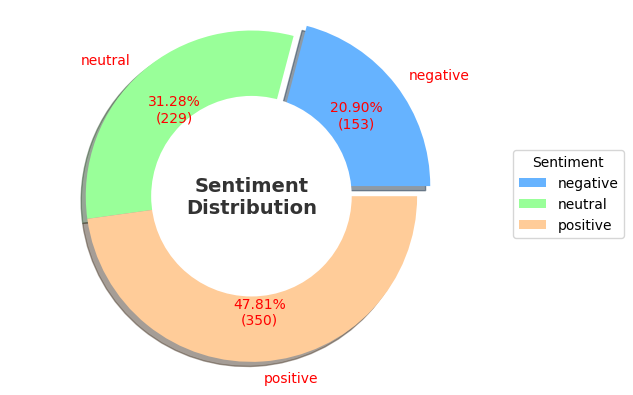

In [24]:
colors = ['#66b3ff', '#99ff99', '#ffcc99']

explode = (0.1, 0, 0)

sentiment_counts = df1.groupby("Sentiment").size()

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    x=sentiment_counts,
    labels=sentiment_counts.index,
    autopct=lambda p: f'{p:.2f}%\n({int(p*sum(sentiment_counts)/100)})',
    wedgeprops=dict(width=0.7),
    textprops=dict(size=10, color="r"),
    pctdistance=0.7,
    colors=colors,
    explode=explode,
    shadow=True)

center_circle = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=1.25)
fig.gca().add_artist(center_circle)

ax.text(0, 0, 'Sentiment\nDistribution', ha='center', va='center', fontsize=14, fontweight='bold', color='#333333')

ax.legend(sentiment_counts.index, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.axis('equal')

plt.show()

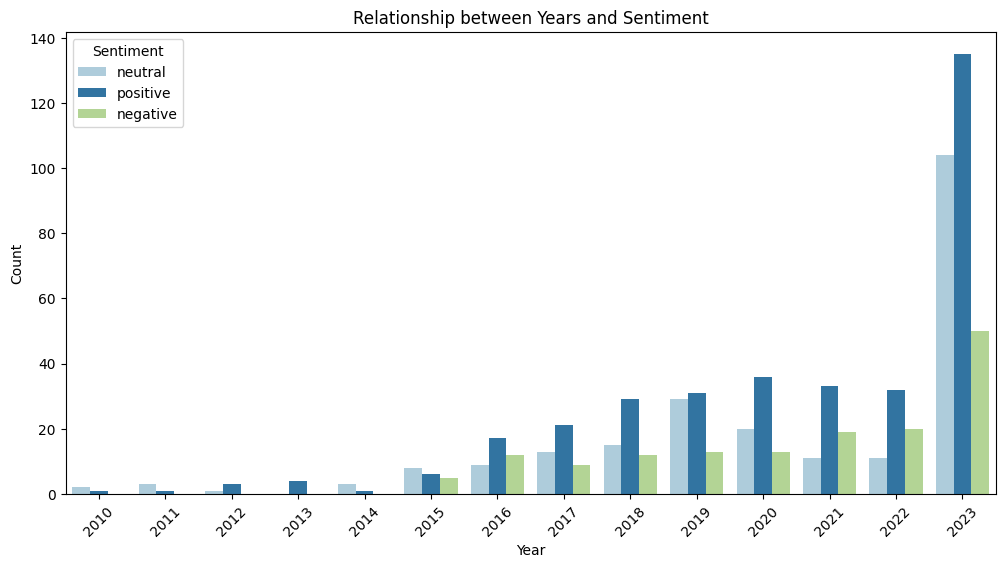

In [25]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Year', hue='Sentiment', data=df1, palette='Paired')
plt.title('Relationship between Years and Sentiment')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

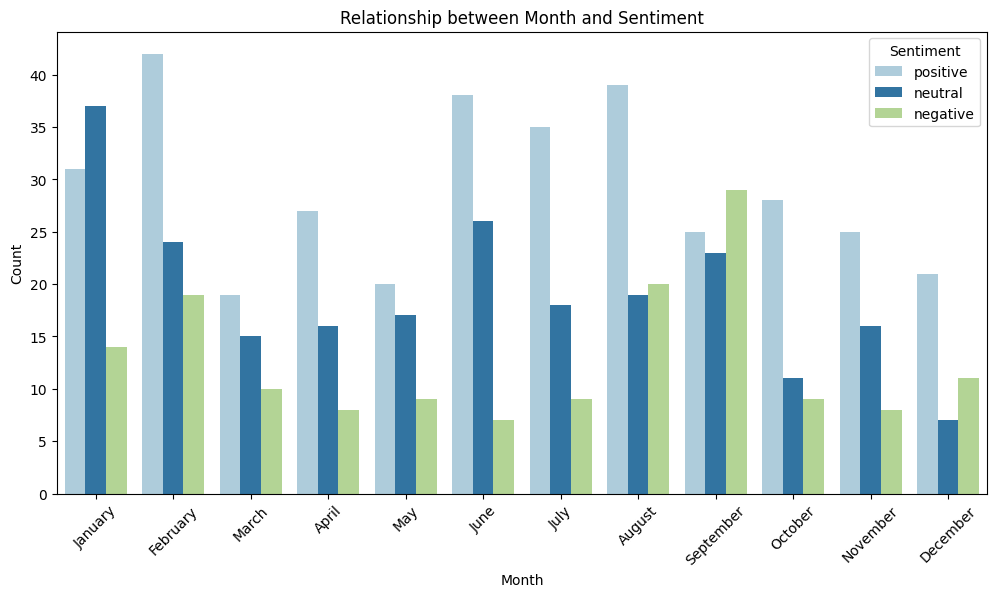

In [26]:
import calendar

month_order = list(calendar.month_name)[1:]

plt.figure(figsize=(12, 6))
sns.countplot(x='Month', hue='Sentiment', data=df1, palette='Paired', order=month_order)
plt.title('Relationship between Month and Sentiment')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

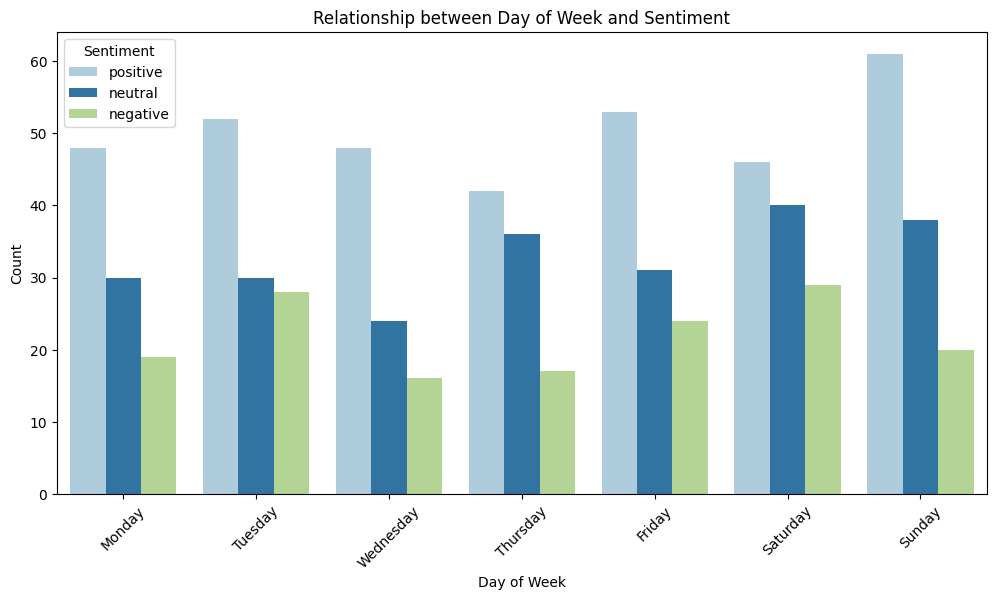

In [27]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12, 6))
sns.countplot(x='Day_of_Week', hue='Sentiment', data=df1, palette='Paired', order=day_order)
plt.title('Relationship between Day of Week and Sentiment')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

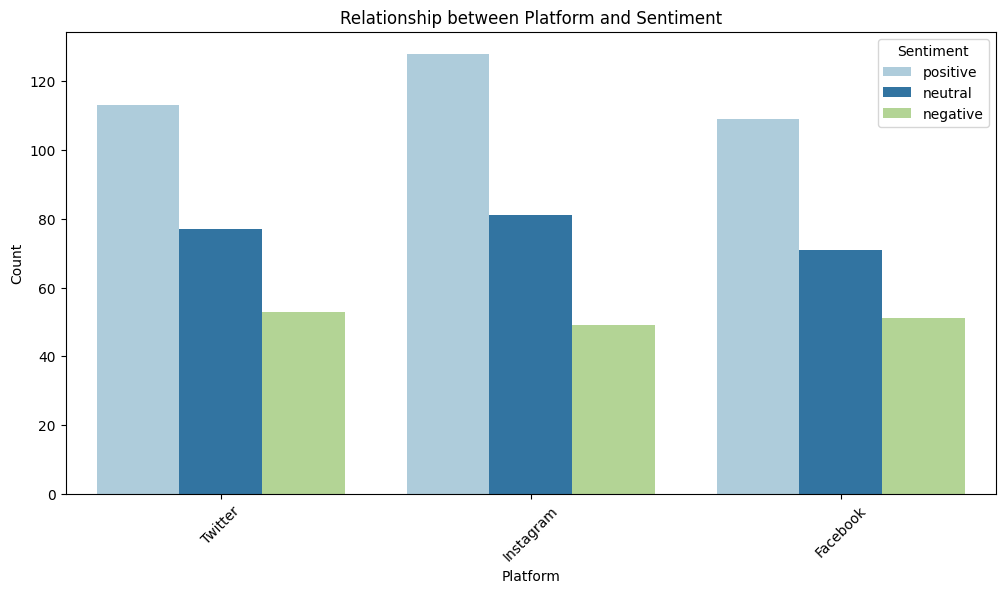

In [28]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Platform', hue='Sentiment', data=df1, palette='Paired')
plt.title('Relationship between Platform and Sentiment')
plt.xlabel('Platform')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

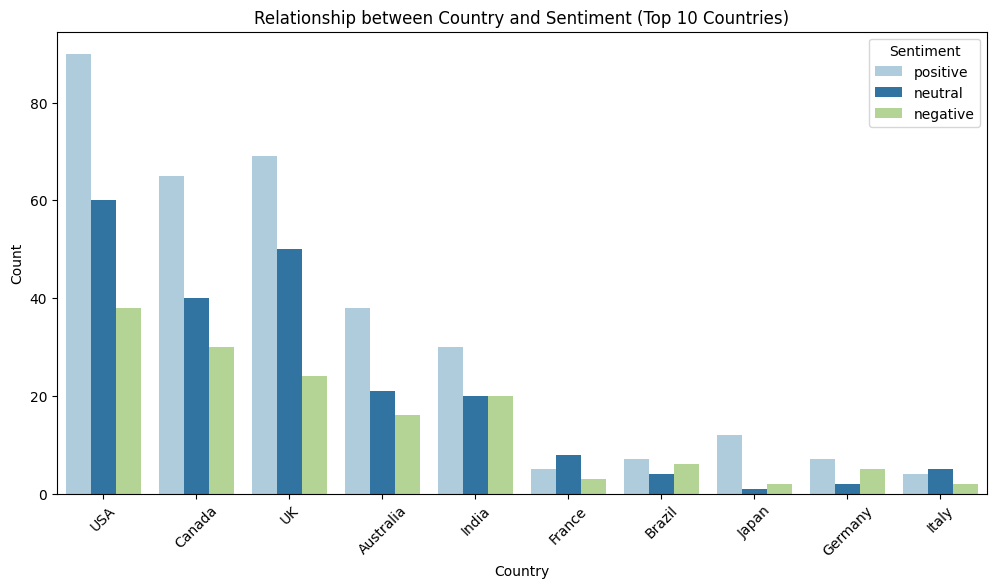

In [29]:
plt.figure(figsize=(12, 6))

top_10_countries = df1['Country'].value_counts().head(10).index

df_top_10_countries = df1[df1['Country'].isin(top_10_countries)]

sns.countplot(x='Country', hue='Sentiment', data=df_top_10_countries, palette='Paired')
plt.title('Relationship between Country and Sentiment (Top 10 Countries)')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Common Words

In [30]:
df1['temp_list'] = df1['Clean_Text'].apply(lambda x: str(x).split())
top_words = Counter([item for sublist in df1['temp_list'] for item in sublist])
top_words_df = pd.DataFrame(top_words.most_common(20), columns=['Common_words', 'count'])

top_words_df.style.background_gradient(cmap='Blues')

,Common_words,count
0,new,43
1,life,37
2,challeng,34
3,joy,31
4,danc,30
5,day,29
6,feel,29
7,like,28
8,dream,28
9,moment,27


In [31]:
df1['temp_list'] = df1['Clean_Text'].apply(lambda x: str(x).split())
top_words = Counter([item for sublist in df1['temp_list'] for item in sublist])
top_words_df = pd.DataFrame(top_words.most_common(20), columns=['Common_words', 'count'])

fig = px.bar(top_words_df,
            x="count",
            y="Common_words",
            title='Common Words in Text Data',
            orientation='h',
            width=700,
            height=700,
            color='Common_words')

fig.show()

In [32]:
Positive_sent = df1[df1['Sentiment'] == 'positive']
Negative_sent = df1[df1['Sentiment'] == 'negative']
Neutral_sent = df1[df1['Sentiment'] == 'neutral']

In [33]:
#Positive Common Words
top = Counter([item for sublist in df1[df1['Sentiment'] == 'positive']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,joy,30
1,friend,24
2,laughter,24
3,new,21
4,challeng,20
5,life,20
6,hope,20
7,dream,20
8,embrac,19
9,like,19


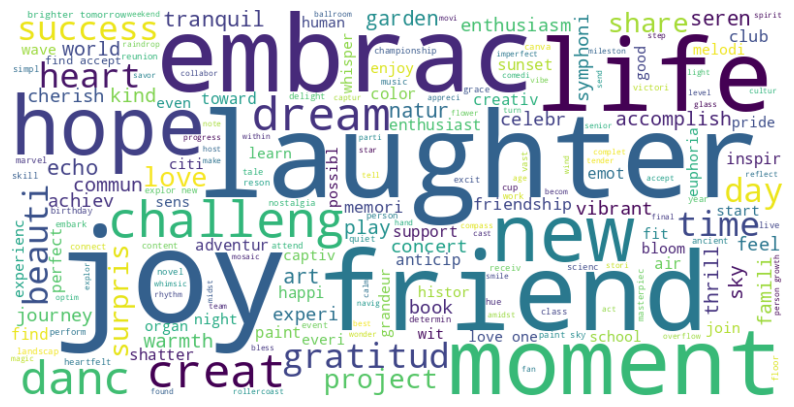

In [34]:
words = ' '.join([item for sublist in df1[df1['Sentiment'] == 'positive']['temp_list'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [35]:
#Neutral Common Words
top = Counter([item for sublist in df1[df1['Sentiment'] == 'neutral']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Blues')

,Common_words,count
0,new,22
1,explor,13
2,excit,12
3,life,12
4,beauti,12
5,night,12
6,danc,12
7,attend,11
8,seren,11
9,feel,10


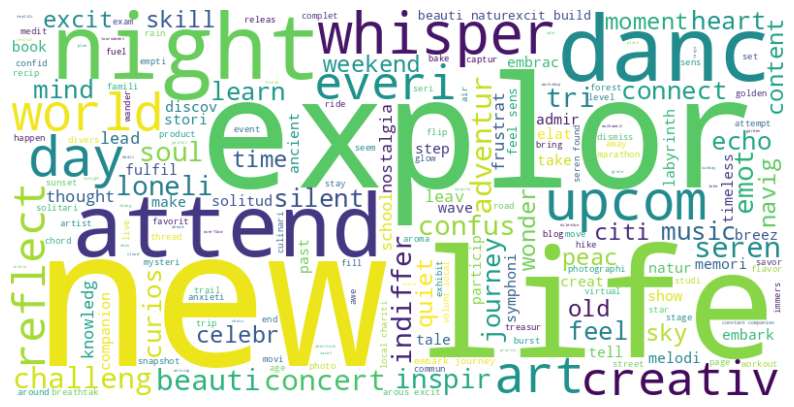

In [36]:
words = ' '.join([item for sublist in df1[df1['Sentiment'] == 'neutral']['temp_list'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [37]:
#Negative Common Words
top = Counter([item for sublist in df1[df1['Sentiment'] == 'negative']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Reds')

,Common_words,count
0,despair,14
1,lost,14
2,emot,13
3,feel,11
4,bitter,10
5,storm,10
6,day,9
7,like,9
8,grief,8
9,heart,8


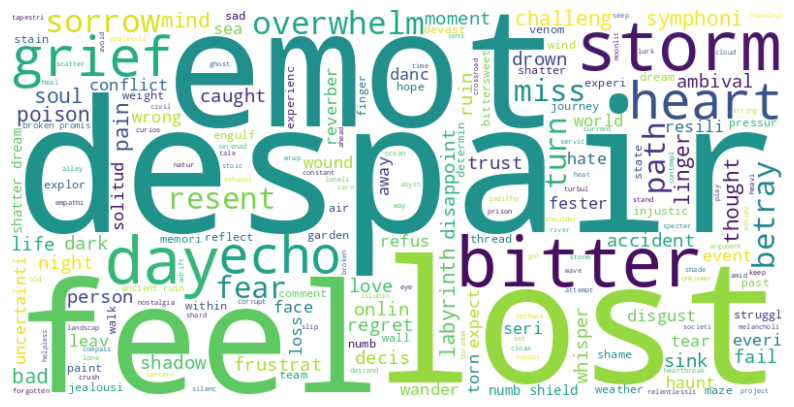

In [38]:
words = ' '.join([item for sublist in df1[df1['Sentiment'] == 'negative']['temp_list'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Data Preparation

In [39]:
df2 = df1.copy()

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

In [41]:
X = df2['Clean_Text'].values
y = df2['Sentiment'].values

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [44]:
pac_classifier = PassiveAggressiveClassifier(max_iter=50, random_state=42)
pac_classifier.fit(X_train_tfidf, y_train)

PassiveAggressiveClassifier(max_iter=50, random_state=42)

In [45]:
y_pred = pac_classifier.predict(X_test_tfidf)
accuracy_test = accuracy_score(y_test, y_pred)
classification_rep_test = classification_report(y_test, y_pred)

In [46]:
print("Test Set Results:")
print(f"Accuracy: {accuracy_test}")
print("Classification Report:\n", classification_rep_test)

Test Set Results:
Accuracy: 0.7142857142857143
Classification Report:
               precision    recall  f1-score   support

    negative       0.79      0.81      0.80        32
     neutral       0.73      0.55      0.62        55
    positive       0.67      0.82      0.74        60

    accuracy                           0.71       147
   macro avg       0.73      0.72      0.72       147
weighted avg       0.72      0.71      0.71       147



In [47]:
logistic_classifier = LogisticRegression(max_iter=50, random_state=42)
logistic_classifier.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=50, random_state=42)

In [48]:
y_pred_logistic = logistic_classifier.predict(X_test_tfidf)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
classification_rep_logistic = classification_report(y_test, y_pred_logistic)
print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_logistic}")
print("Classification Report:\n", classification_rep_logistic)

Logistic Regression Results:
Accuracy: 0.6326530612244898
Classification Report:
               precision    recall  f1-score   support

    negative       0.89      0.50      0.64        32
     neutral       0.80      0.36      0.50        55
    positive       0.55      0.95      0.70        60

    accuracy                           0.63       147
   macro avg       0.75      0.60      0.61       147
weighted avg       0.72      0.63      0.61       147



In [49]:
random_forest_classifier = RandomForestClassifier(random_state=42)
random_forest_classifier.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=42)

In [50]:
y_pred_rf = random_forest_classifier.predict(X_test_tfidf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)
print("\nRandom Forest Results:")
print(f"Accuracy: {accuracy_rf}")
print("Classification Report:\n", classification_rep_rf)


Random Forest Results:
Accuracy: 0.6530612244897959
Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.59      0.70        32
     neutral       0.77      0.44      0.56        55
    positive       0.56      0.88      0.69        60

    accuracy                           0.65       147
   macro avg       0.73      0.64      0.65       147
weighted avg       0.71      0.65      0.64       147



In [51]:
svm_classifier = SVC(random_state=42)
svm_classifier.fit(X_train_tfidf, y_train)

SVC(random_state=42)

In [52]:
y_pred_svm = svm_classifier.predict(X_test_tfidf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
classification_rep_svm = classification_report(y_test, y_pred_svm)
print("Support Vector Machine Results:")
print(f"Accuracy: {accuracy_svm}")
print("Classification Report:\n", classification_rep_svm)

Support Vector Machine Results:
Accuracy: 0.5986394557823129
Classification Report:
               precision    recall  f1-score   support

    negative       1.00      0.38      0.55        32
     neutral       0.94      0.31      0.47        55
    positive       0.50      0.98      0.67        60

    accuracy                           0.60       147
   macro avg       0.82      0.56      0.56       147
weighted avg       0.78      0.60      0.57       147



In [53]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

MultinomialNB()

In [54]:
y_pred_nb = nb_classifier.predict(X_test_tfidf)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
classification_rep_nb = classification_report(y_test, y_pred_nb)
print("\nMultinomial Naive Bayes Results:")
print(f"Accuracy: {accuracy_nb}")
print("Classification Report:\n", classification_rep_nb)


Multinomial Naive Bayes Results:
Accuracy: 0.6190476190476191
Classification Report:
               precision    recall  f1-score   support

    negative       1.00      0.38      0.55        32
     neutral       0.90      0.35      0.50        55
    positive       0.53      1.00      0.69        60

    accuracy                           0.62       147
   macro avg       0.81      0.57      0.58       147
weighted avg       0.77      0.62      0.59       147



### Hyperparameters

In [55]:
param_dist = {
    'C': [0.1, 0.5, 1.0],
    'fit_intercept': [True, False],
    'shuffle': [True, False],
    'verbose': [0, 1],
}

In [56]:
pac_classifier = PassiveAggressiveClassifier(random_state=42)

randomized_search = RandomizedSearchCV(pac_classifier, param_distributions=param_dist, n_iter=5, cv=2, scoring='accuracy', random_state=42)
randomized_search.fit(X_train_tfidf, y_train)

-- Epoch 1
Norm: 8.35, NNZs: 1151, Bias: -0.443430, T: 292, Avg. loss: 0.604776
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 11.40, NNZs: 1165, Bias: -0.325117, T: 584, Avg. loss: 0.216610
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 13.13, NNZs: 1165, Bias: -0.292827, T: 876, Avg. loss: 0.093587
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 13.58, NNZs: 1166, Bias: -0.297056, T: 1168, Avg. loss: 0.024129
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 13.71, NNZs: 1166, Bias: -0.299054, T: 1460, Avg. loss: 0.006232
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 13.74, NNZs: 1166, Bias: -0.298338, T: 1752, Avg. loss: 0.001502
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 13.75, NNZs: 1166, Bias: -0.298039, T: 2044, Avg. loss: 0.000294
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 13.75, NNZs: 1166, Bias: -0.297993, T: 2336, Avg. loss: 0.000047
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 13.75, NNZs: 1166, Bias: -0.297986, T: 2628, Avg. l

RandomizedSearchCV(cv=2, estimator=PassiveAggressiveClassifier(random_state=42),
                   n_iter=5,
                   param_distributions={'C': [0.1, 0.5, 1.0],
                                        'fit_intercept': [True, False],
                                        'shuffle': [True, False],
                                        'verbose': [0, 1]},
                   random_state=42, scoring='accuracy')

In [57]:
best_params_randomized = randomized_search.best_params_
best_params_randomized

{'verbose': 0, 'shuffle': True, 'fit_intercept': True, 'C': 0.5}

In [58]:
best_pac_classifier_randomized = PassiveAggressiveClassifier(random_state=42, **best_params_randomized)
best_pac_classifier_randomized.fit(X_train_tfidf, y_train)

PassiveAggressiveClassifier(C=0.5, random_state=42)

In [59]:
y_pred_best_pac_randomized = best_pac_classifier_randomized.predict(X_test_tfidf)

In [60]:
accuracy_best_pac_randomized = accuracy_score(y_test, y_pred_best_pac_randomized)
classification_rep_best_pac_randomized = classification_report(y_test, y_pred_best_pac_randomized)
conf_matrix_test = confusion_matrix(y_test, y_pred_best_pac_randomized)
print("Best PassiveAggressiveClassifier Model (RandomizedSearchCV):")
print(f"Best Hyperparameters: {best_params_randomized}")
print(f"Accuracy: {accuracy_best_pac_randomized}")
print("Classification Report:\n", classification_rep_best_pac_randomized)

Best PassiveAggressiveClassifier Model (RandomizedSearchCV):
Best Hyperparameters: {'verbose': 0, 'shuffle': True, 'fit_intercept': True, 'C': 0.5}
Accuracy: 0.7278911564625851
Classification Report:
               precision    recall  f1-score   support

    negative       0.84      0.81      0.83        32
     neutral       0.74      0.56      0.64        55
    positive       0.68      0.83      0.75        60

    accuracy                           0.73       147
   macro avg       0.75      0.74      0.74       147
weighted avg       0.73      0.73      0.72       147



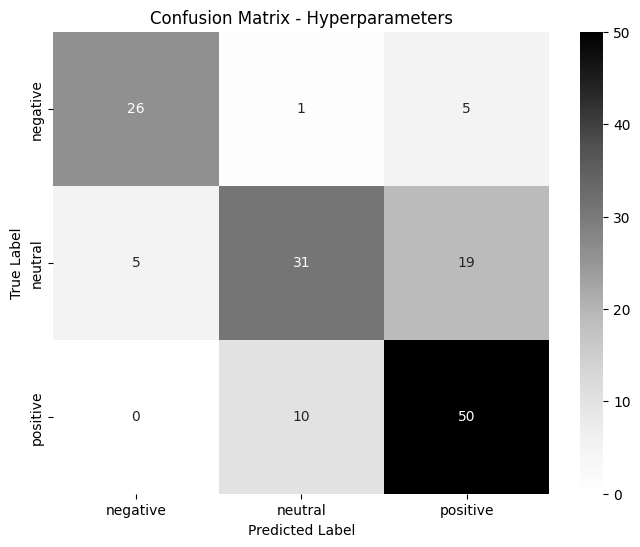

In [61]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Greys', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.title('Confusion Matrix - Hyperparameters')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [62]:
df2.head()

,Text,Timestamp,User,Platform,Retweets,Likes,Country,Year,Month,Day_of_Week,Clean_Text,Vader_Score,Sentiment,temp_list
0,Enjoying a beautiful day at the park! ...,2023-01-15 12:30:00,User123,Twitter,15,30,USA,2023,January,Sunday,enjoy beauti day park,0.4939,positive,"[enjoy, beauti, day, park]"
1,Traffic was terrible this morning. ...,2023-01-15 08:45:00,CommuterX,Twitter,5,10,Canada,2023,January,Sunday,traffic terribl morn,0.0000,neutral,"[traffic, terribl, morn]"
2,Just finished an amazing workout! 💪 ...,2023-01-15 15:45:00,FitnessFan,Instagram,20,40,USA,2023,January,Sunday,finish amaz workout,0.0000,neutral,"[finish, amaz, workout]"
3,Excited about the upcoming weekend getaway! ...,2023-01-15 18:20:00,AdventureX,Facebook,8,15,UK,2023,January,Sunday,excit upcom weekend getaway,0.0000,neutral,"[excit, upcom, weekend, getaway]"
4,Trying out a new recipe for dinner tonight. ...,2023-01-15 19:55:00,ChefCook,Instagram,12,25,Australia,2023,January,Sunday,tri new recip dinner tonight,0.0000,neutral,"[tri, new, recip, dinner, tonight]"
